# KC housing price prediction

## Model : Ridge (L2) regression

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

df = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)
df = df.sort_values(['sqft_living','price'])


#### Function to create polynomial features

In [3]:
def polynomial_df(col, k):
    df = pd.DataFrame()
    df['power_1'] = col
    for i in range(2, k+1):
        df['power_' + str(i)] = np.power(col,i)
    return df

### Model - Ridge, deg 15 polynomial, L2 of 1.5e-5:

In [4]:
l2_small_penalty = 1.5e-5

poly15 = polynomial_df(df['sqft_living'], 15) # use equivalent of `polynomial_sframe`
model = linear_model.Ridge(alpha=l2_small_penalty, normalize=True)
model.fit(poly15, df['price'])

coefs = model.coef_
intercept = model.intercept_
print("intercept is: {}".format(intercept))
print("coefs are: {}".format(coefs))

intercept is: 220664.37505420734
coefs are: [ 1.24873306e+02 -4.77376011e-02  3.01446238e-05 -2.44419942e-09
 -1.94153675e-13  8.54085686e-18  1.51142121e-21  8.27979094e-26
  6.52603100e-31 -3.27895017e-34 -3.87962315e-38 -2.72437650e-42
 -1.07790800e-46  3.78242694e-51  1.39790296e-54]


In [5]:
# coefficient of feature power_1
coefs[0]

124.87330648149118

In [6]:
set_1 = pd.read_csv('wk3_kc_house_set_1_data.csv', dtype=dtype_dict)
set_2 = pd.read_csv('wk3_kc_house_set_2_data.csv', dtype=dtype_dict)
set_3 = pd.read_csv('wk3_kc_house_set_3_data.csv', dtype=dtype_dict)
set_4 = pd.read_csv('wk3_kc_house_set_4_data.csv', dtype=dtype_dict)

In [7]:
l = [set_1, set_2,set_3,set_4]
l2_small_penalty=1e-9

### Fit a 15th degree polynomial on each of the 4 sets, plot the results and view the weights for the four models

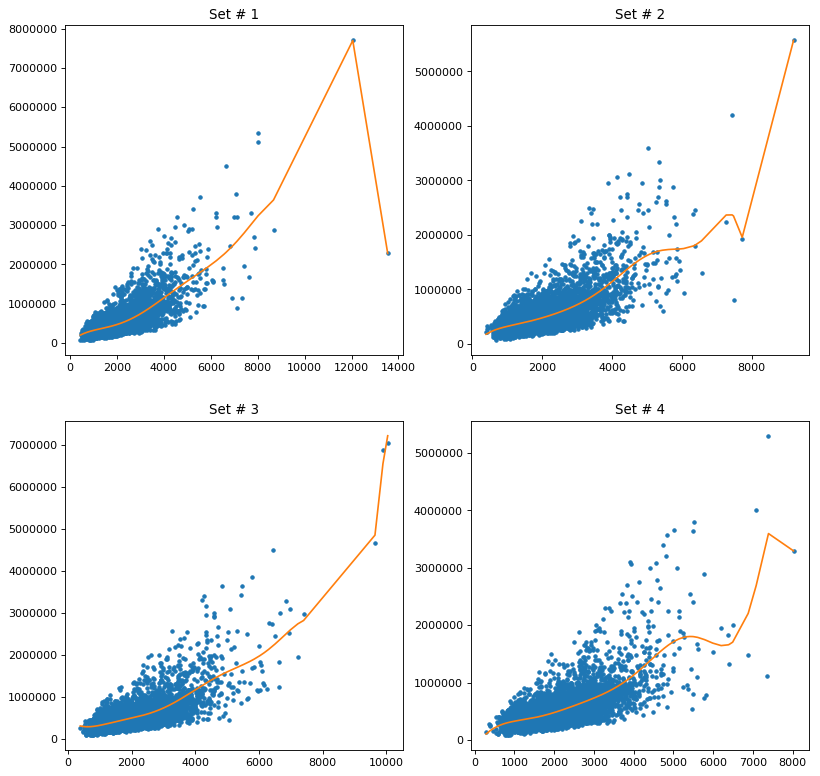

In [10]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
mod = []
for i,s in zip(range(1,5),l):
    poly15 = polynomial_df(s['sqft_living'], 15) 
    model = linear_model.Ridge(alpha=l2_small_penalty, normalize=True)
    mod.append(model.fit(poly15, s['price']))
    plt.subplot(2, 2, i)
    plt.title('Set # {}'.format(i))
    plt.plot(poly15['power_1'], s['price'],'.',
             poly15['power_1'], model.predict(poly15),'-')

In [11]:
[m.coef_[0] for m in mod]

[544.669417971042, 859.3626579383513, -755.3958663532549, 1119.4456982116394]

### Fit a 15th-order polynomial model on set_1, set_2, set_3, and set_4, this time with a large L2 penalty

[2.3280680295793252, 2.097569027778555, 2.2890625811892047, 2.0859619409193066]

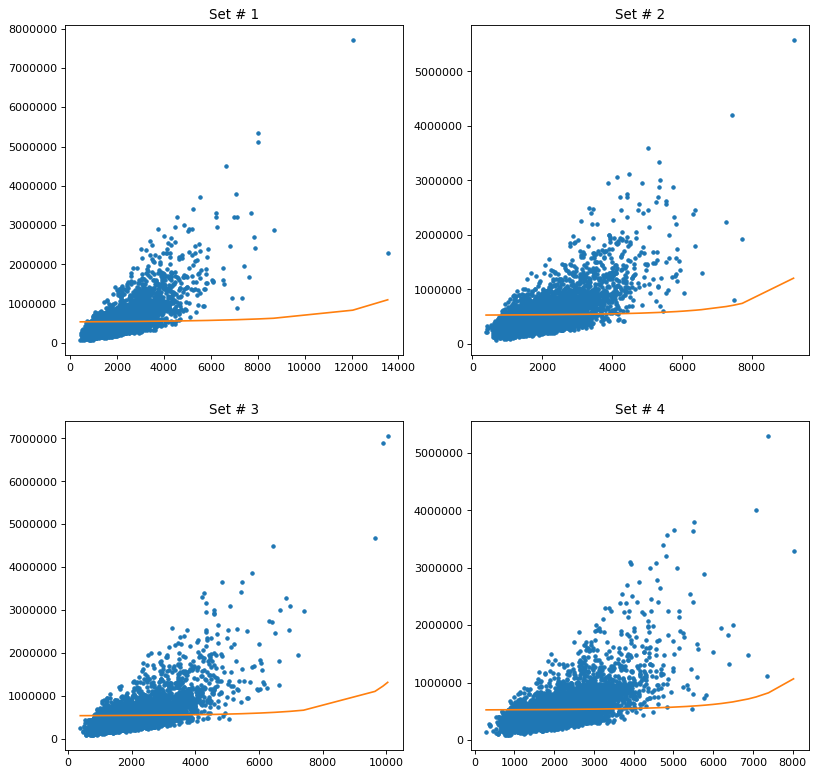

In [13]:
figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
l2_large_penalty=1.23e2

mod = []
for i,s in zip(range(1,5),l):
    poly15 = polynomial_df(s['sqft_living'], 15) # use equivalent of `polynomial_sframe`
    model = linear_model.Ridge(alpha=l2_large_penalty, normalize=True)
    mod.append(model.fit(poly15, s['price']))
    plt.subplot(2, 2, i)
    plt.title('Set # {}'.format(i))
    plt.plot(poly15['power_1'], s['price'],'.',
             poly15['power_1'], model.predict(poly15),'-')
    
[m.coef_[0] for m in mod]

## KFold CV

In [14]:
train_valid_shuffled = pd.read_csv('wk3_kc_house_train_valid_shuffled.csv', dtype=dtype_dict)
test = pd.read_csv('wk3_kc_house_test_data.csv', dtype=dtype_dict)

In [15]:
n = len(train_valid_shuffled)
k = 10 # 10-fold cross-validation

for i in range(k):
    start = (n*i)/k
    end = (n*(i+1))/k-1
    print(i, (start, end))

0 (0.0, 1938.6)
1 (1939.6, 3878.2)
2 (3879.2, 5817.8)
3 (5818.8, 7757.4)
4 (7758.4, 9697.0)
5 (9698.0, 11636.6)
6 (11637.6, 13576.2)
7 (13577.2, 15515.8)
8 (15516.8, 17455.4)
9 (17456.4, 19395.0)


In [16]:
from sklearn.model_selection import KFold

def k_fold_cross_validation(k, l2_penalty, data, output):
    kf = KFold(n_splits = k)
    average_validation_error = 0.
    for train_index, val_index in kf.split(data):
        X_train, X_test = data.iloc[train_index], data.iloc[val_index]
        Y_train, Y_test = output.iloc[train_index], output.iloc[val_index]
        #poly15 = polynomial_df(s['sqft_living'], 15) # use equivalent of `polynomial_sframe`
        model = linear_model.Ridge(alpha=l2_penalty, normalize=True)
        #mod.append(model.fit(poly15, s['price']))
        model.fit(X_train, Y_train)
        rss = np.sum((Y_test - model.predict(X_test))**2)
        average_validation_error = rss/k
    return average_validation_error

In [17]:
penalties = np.logspace(3, 9, num=13)

min_err = 0.
l2_pen_min = None

In [18]:
for l2_penalty in penalties:
    poly15 = polynomial_df(train_valid_shuffled['sqft_living'],15)
    output = train_valid_shuffled['price']
    av_val_err = k_fold_cross_validation(10, l2_penalty, poly15, output)
    if l2_pen_min == None:
        min_err = av_val_err
        l2_pen_min = l2_penalty
    elif min_err > av_val_err:
        min_err = av_val_err
        l2_pen_min = l2_penalty

In [19]:
l2_pen_min, min_err

(1000.0, 31188436130691.273)

### Using the best L2 penalty found above, train a model using all training data. Print RSS on the TEST data of the model

In [21]:
poly15 = polynomial_df(train_valid_shuffled['sqft_living'],15)
output = train_valid_shuffled['price']
model = linear_model.Ridge(alpha=l2_pen_min, normalize=True)
#mod.append(model.fit(poly15, s['price']))
model.fit(poly15, output)
test_poly15 = polynomial_df(test['sqft_living'],15)
test_output = test['price']
rss = np.sum((test_output - model.predict(test_poly15))**2)
rss

283856861224150.9